In [0]:
"""
A lot of codes and ideas has been taken from 'https://www.kaggle.com/basu369victor/kuzushiji-recognition-just-like-digit-recognition',
I have added a lot of comments to make the code very readable.
"""
from PIL import ImageFont,Image,ImageDraw
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
%matplotlib inline

In [15]:
#Upgraded the kaggle API as my Kaggle API was not up to date.
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v


Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
Kaggle API 1.5.6


In [16]:
#Downloading the dataset from the kaggle.
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c kuzushiji-recognition


kuzushiji-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [17]:
!unzip kuzushiji-recognition
!mkdir data
!mkdir data/train_imgs/
!mkdir data/test_imgs/
!unzip train_images -d data/train_imgs/
!unzip test_images -d data/test_imgs/

Archive:  kuzushiji-recognition.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_images.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: m
error:  invalid response [m]
replace test_images.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/train_imgs/’: File exists
mkdir: cannot create directory ‘data/test_imgs/’: File exists
Archive:  train_images.zip
replace data/train_imgs/200021660-00082_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test_images.zip
replace data/test_imgs/test_52763334.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [18]:
#Downloading Japanese Noto Sans font to visualise japanese unicode digits.
# From https://www.google.com/get/noto/
!wget -q --show-progress https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
!unzip -p NotoSansCJKjp-hinted.zip NotoSansCJKjp-Regular.otf > NotoSansCJKjp-Regular.otf
!rm NotoSansCJKjp-hinted.zip

font = ImageFont.truetype('./NotoSansCJKjp-Regular.otf', 50, encoding='utf-8')

NotoSansCJKjp-hinte 100%[===================>] 115.49M   123MB/s    in 0.9s    


In [0]:
train_df=pd.read_csv('/content/train.csv')
#Creating dictionary that maps unicode to actual characters.
unicode_map = {codepoint: char for codepoint, char in pd.read_csv('unicode_translation.csv').values}



In [20]:
train_df.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


100241706_00004_2


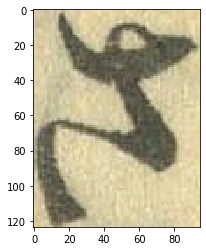

In [43]:
#Some experimentation.
img_name=train_df['image_id'].values[0]
labels=np.array(train_df['labels'].values[0].split(' ')).reshape(-1,5)
labels=labels[15]
print(img_name)
img=cv2.imread('data/train_imgs/100241706_00004_2.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
x,y,w,h=int(labels[1]),int(labels[2]),int(labels[3]),int(labels[4])
plt.imshow(img[y:y+h, x:x+w])

In [21]:
#Cropping digit from page and creating digit image and label pair.
data=[]
tar=[]
for img_n,label in (train_df[:420].values):
  labels=np.array(label.split(' ')).reshape(-1,5) # Resizing into n x 5 array as the label is encoded as (image,x,y,width,height)
  img=cv2.imread('data/train_imgs/'+img_n+'.jpg') 
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
  for uc,x,y,w,h in labels:
    x, y, w, h =int(x),int(y),int(w),int(h)
    char_img=img[y:y+h, x:x+w] #Crops the image using the coordinates provided in the labels.
    
    
    char_img=cv2.resize(char_img,(300,300)) #Resizing the image to 300 x 300
    char_img=np.asarray(char_img)
    char_img=cv2.cvtColor(char_img,cv2.COLOR_RGB2GRAY)
    ret,th1 = cv2.threshold(char_img,155,255,cv2.THRESH_BINARY_INV) #Applying binary inversion thresholding to have more sharp edges to detect.
    data.append(th1)
    tar.append(str(unicode_map[uc])) #Converting the unicode to real character.
print(np.array(data).shape)
print(np.array(tar).shape)









(51840, 300, 300)
(51840,)


In [23]:
data=np.array(data)
tar=np.array(tar)
unique, counts = np.unique(tar, return_counts=True)
print(unique, counts )
print("Unique Class=",len(unique))


['?' '▲' '○' ... '鼎' '鼻' '蓮'] [  1  54 198 ...   6   1   1]
Unique Class= 1465


In [0]:
#This function converts the data into 300 x 300 size image and performs one hot encoding of labels.
def PreProcessData(X,y):
    lb = LabelEncoder() 
    y_integer = lb.fit_transform(y)#Encodes into integer.
    out_y = to_categorical(y_integer) #One hot enocoding.
    num_images = X.shape[0]
    out_x = X.reshape(num_images, 300, 300, 1)
    #out_x = x_shaped_array / 255
    return out_x, out_y

  




In [0]:
#Seperately calling Label enocoder so that it can be used to remap the predicted integer labels to its string value(real label).
lb=LabelEncoder()
y_map=lb.fit_transform(tar)

In [0]:
X,y=PreProcessData(data,tar)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [37]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization,Dropout
#Building the Sequential CNN model to recognize the digit after detection.
def build_model(input_shape):
  model=Sequential()
  model.add(Conv2D(32,(3,3),input_shape=input_shape,activation='relu', padding="same"))
  model.add(BatchNormalization())

  model.add(Conv2D(32,(3,3),activation='relu', padding="same"))
  model.add(BatchNormalization())

  model.add(Conv2D(32,(5,5),activation='relu', padding="same"))
  model.add(MaxPool2D(2,2))
  model.add(BatchNormalization())

  model.add(Dropout(0.4))
  model.add(Conv2D(64,(3,3),strides=2,activation='relu', padding="same"))
  model.add(MaxPool2D(2,2))
  model.add(BatchNormalization())

  model.add(Conv2D(64,(3,3),strides=2,activation='relu', padding="same"))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.4))

  model.add(Dense(len(unique), activation='softmax'))
  return model

ku_model=build_model((300,300,1))
ku_model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
ku_model.summary()





  





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 300, 300, 32)      320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 300, 300, 32)      128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 300, 300, 32)      9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 300, 300, 32)      128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 300, 300, 32)      25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 150, 150, 32)      0         
___

In [40]:
#Training the model.
checkpointer = ModelCheckpoint('model_Kuzushiji.h5', verbose=0,mode='auto', monitor='val_acc',save_best_only=True)
history=ku_model.fit(X_train,y_train,batch_size=100,epochs=32,verbose=1,callbacks=[checkpointer],validation_data=(X_val,y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 38880 samples, validate on 12960 samples
Epoch 1/32
38880/38880 [==============================] - 237s 6ms/step - loss: 3.8404 - acc: 0.3171 - val_loss: 2.4582 - val_acc: 0.5565
Epoch 2/32
38880/38880 [==============================] - 226s 6ms/step - loss: 2.6944 - acc: 0.4740 - val_loss: 2.1159 - val_acc: 0.6160
Epoch 3/32
38880/38880 [==============================] - 226s 6ms/step - loss: 2.2858 - acc: 0.5342 - val_loss: 1.7800 - val_acc: 0.6754
Epoch 4/32
38880/38880 [==============================] - 226s 6ms/step - loss: 2.0123 - acc: 0.5761 - val_loss: 1.6402 - val_acc: 0.6953
Epoch 5/32
38880/38880 [==============================] - 226s 6ms/step - loss: 1.8396 - acc: 0.5971 - val_loss: 1.5493 - val_acc: 0.7123
Epoch 6/32
38880/38880 [==============================] - 226s 6ms/step - loss: 1.6786 - acc: 0.6195 - val_loss: 1.4964 - val_acc: 0.7219
Epoch 7/32
38880/38880 [==

Text(0.5, 1.0, 'Loss Curves')

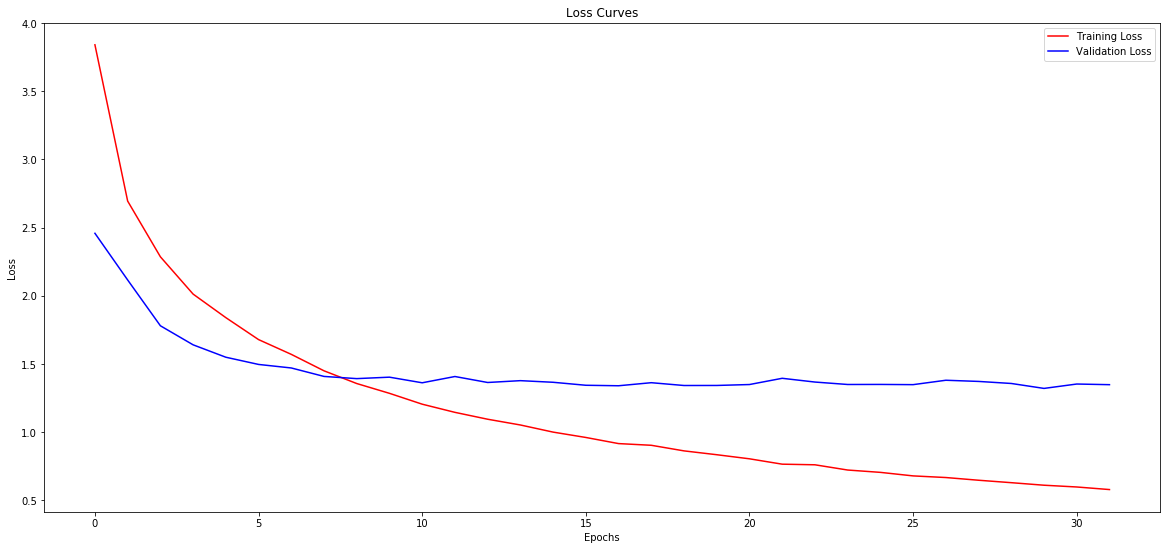

In [46]:
#Loss Curves
plt.figure(figsize=[20,9])
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

In [0]:
#Lets now create a function which predicts all the characters on the image.
def VisualiseCharacter(imgpath):
  img=cv2.imread(imgpath)
  imsource = Image.open(imgpath)
  char_draw = ImageDraw.Draw(imsource)
  im_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret, im_th = cv2.threshold(im_grey, 130, 255, cv2.THRESH_BINARY_INV)
  ctrs,_ = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #Detects the contours of the charcters which can be used to crop the image to be detected.
  rects = [cv2.boundingRect(ctr) for ctr in ctrs] #The function cv2.bundingRect returns the approx bounting box around the detected contour.
  Kuzushijis = []
  for rect in rects:
        leng = int(rect[3] * 1.6) #Calculating the length of character.
        pt1 = int(rect[1] + rect[3]//2 - leng// 2)
        pt2 = int(rect[0] + rect[2]//2 - leng// 2)
        roi = im_th[pt1:pt1+leng, pt2:pt2+leng] #Getting the region of interest where char is present which will be passed to the preprocessing function and then to model.
        if roi.size>7000:
            cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (225, 0, 0), 6) #Creating bounding boxes around the contours obtained.
            roi = cv2.resize(roi, (300,300)) #Resizing the roi to 300 x 300 as the model was trained to predict on 300 x 300 size image.
            #roi = cv2.dilate(roi, (3, 3))
            ret,th1 = cv2.threshold(roi,155,255,cv2.THRESH_BINARY) #Thresholding again.
            ProcessImage = th1.reshape(1,300, 300, 1) 
            y_pred = ku_model.predict(ProcessImage) #Getting probability distribution of the characters
            y_true = np.argmax(y_pred,axis=1) #The character the max probability is the predicted character.
            Kuzushiji = lb.inverse_transform(y_true) #Transforming the integre value to original character name using label encoder.
           
            Kuzushijis.append(str(Kuzushiji[0]))
            char_draw.text((rect[0]+10, rect[1]),str(Kuzushiji[0]), fill=(0,22,225,0), font=font)
            #cv2.putText(img, str(Kuzushiji[0]), (rect[0], rect[1]),font, 2, (0, 255, 255), 3)
  return img,imsource



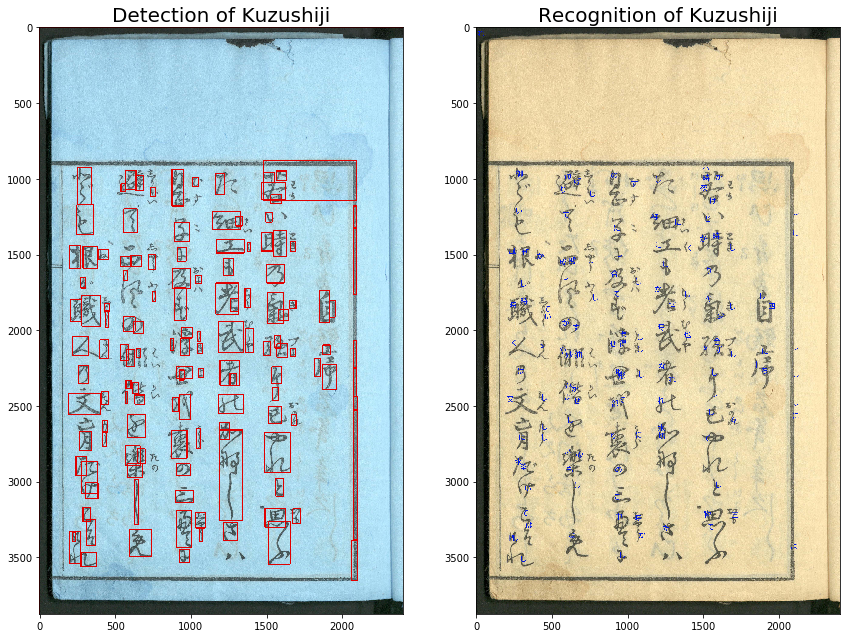

In [63]:
#Lets test it on image an visualize the image.
img1, imsource1 = VisualiseCharacter('data/train_imgs/100241706_00004_2.jpg')
plt.figure(figsize=(30,30))
plt.subplot(1,4,1)
plt.title("Detection of Kuzushiji",fontsize=20)
plt.imshow(img1)
plt.subplot(1,4,2)
plt.title("Recognition of Kuzushiji",fontsize=20)
plt.imshow(imsource1)

